
---

# CORAL Models for Behavior Prediction under Distribution Shift

**Author:** Medha Agarwal
**Last Modified:** December 03, 2025

This notebook demonstrates **domain adaptation** for wildlife behavior prediction to address the **distribution shift** between the source (labeled) data and the target (unlabeled & weakly labeled) data.

We employ **CORrelation ALignment (CORAL)**, for domain adaptation that trasfers models trained on **Vectronics acceleration data** to the **RVC dataset** by adjustng the covariates.

The notebook covers the following key steps:
1.  **STEP 1. Load data** Loading and transforming raw sensor features
2.  **STEP 2. Training models** Training the FixMatch domain adaptation model
3.  **STEP 3. Model evaluation** Assessing performance via predictions on held-out laeled source and target samples
4.  **STEP 4. Calibration** Calibrating the prediction scores to satisfy a pre-determined label distribution
5.  **STEP 5. Prediction and saving outputs** Saving the uncalibrated and calibrated prediction scores

The notebook expects the following preprocessed data files to be available in the `data/` directory:

* `Vectronics_preprocessed_duration30.0.csv` — generated by `scripts/run_Vectronics_preprocessing.py`
* `Vectronics_full_summary.csv` — generated by `scripts/run_Vectronics_preprocessing.py`
* `RVC_preprocessed.csv` — generated by `scripts/run_RVC_preprocessing.py`

---


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Import modules
import sys
sys.path.append(".")
sys.path.append("../")
sys.path.append("../../")
import os
import yaml
import json
import numpy as np
import pandas as pd
from dataclasses import dataclass, field, asdict
from typing import List, Optional

import torch
from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [5]:
# Script imports

import config as config

# utility functions
import src.utils.io as io
import src.utils.preprocess as preprocess
from src.utils.vectronics_data_prep import setup_multilabel_dataloaders
import src.utils.datasets as datasets
from src.utils.train import train_coral
from src.utils.vectronics_preprocessing import modify_vectronics_labels
from src.utils.plots import multi_label_predictions, plot_multiclass_threshold_diagnostics, make_multilabel_confusion_matrices
import src.utils.functionalities as func

# method functions
from src.methods.coral import SimpleFeatureNet
from src.methods.calibration import calibration

# evaluation functions
from src.eval.eval_utils import evaluate_multilabel_distribution

In [6]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = False

The arguments listed below provide a complete set of configurable parameters for the ML pipeline. The `exp_name` argument should be set to a user-defined string. All training and evaluation results are saved in the directory:

```
results/domain_adaptation_training_results/coral/{args.exp_name}_{timestamp}
```

Here, `timestamp` is automatically generated when creating the `root_dir` and follows the format `%Y-%m-%d_%H-%M-%S`.

Users should update the arguments below according to their requirements and provide an informative `exp_name`. Additionally, all argument values are saved in the experiment directory in a file named `config.json` for reference and reproducibility.


In [21]:
@dataclass
class TrainConfig:
    # ---------------- Experiment ----------------
    exp_name: str = "DEFAULT"

    # ---------------- Data ----------------
    source_data_path: Optional[str] = None

    # ---------------- Feature setup ----------------
    pos_idx: Optional[List[int]] = field(
        default_factory=lambda: [0, 1, 2, 3, 4, 5]
    )
    center_idx: Optional[List[int]] = None
    source_padding_duration: Optional[float] = None

    # ---------------- Preprocessing ----------------
    keep_confidence_levels: Optional[List[str]] = None # optionally give a list of confidence levels to retain like ['H', 'M']
    eating_to_other: Optional[List[str]] = None # optionally give a list of eating levels to convert to Other like ['H', 'M']
    eating_to_exclude: Optional[List[str]] = None # optionally give a list of confidence levels to remove from eating like ['H', 'M']
    n_sample_per_target: int = 200_000

    # ---------------- Model ----------------
    feat_dim: int = 128

    # ---------------- Training ----------------
    theta: float = 0.3
    num_epochs: int = 200
    batch_size: int = 512
    learning_rate: float = 1e-3
    weight_decay: float = 0.0
    lambda_coral: float = 1.0
    test_frac: float = 0.2
    device: int = 1
    seed: int = 0

args = TrainConfig()

In [ ]:
np.random.seed(seed=args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
root_dir = os.path.join(io.get_domain_adaptation_results_dir(), "coral")
root_dir = io.get_exp_dir(output_root=root_dir, exp_name=args.exp_name)
os.makedirs(root_dir, exist_ok=True)

with open(os.path.join(root_dir, "config.json"), "w") as f:
    json.dump(asdict(args), f, indent=4, sort_keys=True)

## STEP 1. Load and Inspect Preprocessed Data

In this step, we load two preprocessed datasets:
(1) the **high-frequency Vectronics acceleration data** recorded at 16 Hz, and
(2) the **lower-frequency RVC behavioral data** that provides summarized measurements (over 30 seconds windows).

To ensure both datasets are comparable in scale, we apply **log-transformations** and **truncations** to key continuous variables and perform **initial visualization** to explore their marginal distributions. These plots reveal a **substantial distribution shift** between the source domain (Vectronics) and the target domain (RVC): a central challenge motivating our calibration and domain adaptation pipeline.

---

### 🟦 Vectronics Data (Source Domain)

Run the preprocessing script:

```
scripts/run_Vectronics_preprocessing.py
```

This script converts raw high-frequency data into summary statistics aggregated over **30-minute windows**, matching the resolution of the RVC data. The output is saved to:

```
data/Vectronics_preprocessed_duration30.0.csv
```

At the time of this notebook’s creation, this file is approximately **86 MB**.

Expected columns include:

| Helper Metadata Features (7)   | Summary Acceleration Features (9) |
| ------------------------------ | ------------------------- |
| animal_id                      | acc_x_mean                |
| UTC date [yyyy-mm-dd]          | acc_y_mean                |
| UTC time [yyyy-mm-dd HH:MM:SS] | acc_z_mean                |
| behavior                       | acc_x_ptp_max             |
| Source                         | acc_x_ptp_mean            |
| Confidence (H-M-L)             | acc_y_ptp_max             |
| Eating intensity               | acc_y_ptp_mean            |
|                                | acc_z_ptp_max             |
|                                | acc_z_ptp_mean            |

---

### 🟥 RVC Data (Target Domain)

Run the preprocessing script:

```
scripts/run_RVC_preprocessing.py
```

This script:

* Combines raw data files,
* Performs calibration using collar metadata,
* Removes outliers and invalid observations.

The cleaned dataset is stored at:

```
data/RVC_preprocessed.csv
```

At the time of this notebook’s creation, this dataset is approximately **1.63 GB**.

Expected columns include:

| Helper Metadata Features (9)   | Summary Acceleration Features (9) |
| ------------------------------ | ------------------------- |
| animal_id                      | acc_x_mean                |
| UTC date [yyyy-mm-dd]          | acc_y_mean                |
| UTC time [yyyy-mm-dd HH:MM:SS] | acc_z_mean                |
| collar_number                  | acc_x_ptp_max             |
| range                          | acc_x_ptp_mean            |
| firmware_major_version         | acc_y_ptp_max             |
| est_dist_m_smooth              | acc_y_ptp_mean            |
| resting_binary                 | acc_z_ptp_max             |
| moving_binary                  | acc_z_ptp_mean            |
| feeding_binary                 |                           |



In [9]:
## load configs

with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)
with open(config.RVC_PREPROCESSING_YAML) as f:
    RVC_preprocessing_config = yaml.safe_load(f)
    
assert Vectronics_preprocessing_config['feature_cols'] == RVC_preprocessing_config['feature_cols'], "Feature columns must match between Vectronics and RVC preprocessing configs"
Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']

The source data is loaded from `args.source_data_path` if it is not `None`. Otherwise, the Vectronics data is loaded from the path returned by
`io.get_Vectronics_preprocessed_path(args.source_padding_duration)`. When `args.source_padding_duration` is `None` (i.e., no padding is applied), this function resolves to the default path:

```
/data/Vectronics_preprocessed.csv
```

Use the `modify_vectronics_labels` function to adjust the Vectronics behavior labels according to the following parameters:

* **`keep_confidence_levels`**: List of confidence levels to retain.
* **`eating_to_other`**: List of eating intensity labels to recategorize as `Other`.
* **`eating_to_exclude`**: List of eating intensity labels to remove entirely from the dataset.


In [10]:
print("Loading lableded source data (Vectronics)...")
if args.source_data_path is not None and os.path.exists(args.source_data_path ):
    labeled_vectronics_df = pd.read_csv(args.source_data_path)
elif os.path.exists(io.get_Vectronics_preprocessed_path(args.source_padding_duration)):
    labeled_vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(args.source_padding_duration))
else:
    raise FileNotFoundError

labeled_vectronics_df = modify_vectronics_labels(labeled_vectronics_df, 
                                                 keep_confidence_levels=args.keep_confidence_levels, 
                                                 eating_to_other=args.eating_to_other, 
                                                 eating_to_exclude=args.eating_to_exclude)

print("Loading unlabeled source data (Vectronics)...")
unlabeled_vectronics_df = pd.read_csv(io.get_Vectronics_full_summary_path())

print("Loading target data (RVC)...")
RVC_df = pd.read_csv(io.get_RVC_preprocessed_path())
RVC_df = RVC_df.drop_duplicates().reset_index(drop=True)

RVC_labeled_mask = RVC_df['behavior'].notna()

Loading lableded source data (Vectronics)...
Loading unlabeled source data (Vectronics)...
Loading target data (RVC)...


In [11]:
# create labeled source, unlabeled source, and target data tensors

X_src = labeled_vectronics_df[Vectronics_feature_cols].values
y_src = labeled_vectronics_df['behavior'].values
classes, counts = np.unique(y_src, return_counts=True)

print("LABELED SOURCE DATA")
print(f"Total observations: {X_src.shape[0]}")
print(f"Class distribution:")
for cls, count in zip(classes, counts):
    print(f" - {cls}: {count}, ({count / X_src.shape[0]:.2%})")
print("")
label_encoder = LabelEncoder()
y_src = label_encoder.fit_transform(y_src)

X_src_full = unlabeled_vectronics_df[Vectronics_feature_cols].values
print("UNLABELED SOURCE DATA")
print(f"Total observations: {X_src_full.shape[0]}")
print("")

#----------------------
# filter target data to be within labeled source data range and greater than 0
# comment this chunk of code to prevent the model from filtering out the 
# RVC data lying outside the range of labeled source data
left_limit = np.quantile(X_src, 0.0, axis=0)
right_limit = np.quantile(X_src, 1.0, axis=0)
right_limit = np.where(right_limit == left_limit, left_limit + 1e-6, right_limit)

Xt = RVC_df[Vectronics_feature_cols].values
mask = (Xt >= left_limit).all(axis=1) & (Xt <= right_limit).all(axis=1) & (Xt > 0.0).all(axis=1)
RVC_df = RVC_df[mask].reset_index(drop=True)

# filter the unlabeled source data to be within labeled source data range and greater than 0
# comment this chunk of code to prevent the model from filtering out the 
# unlabeled source data lying outside the range of labeled source data
mask = (X_src_full >= left_limit).all(axis=1) & (X_src_full <= right_limit).all(axis=1)  & (X_src_full > 0.0).any(axis=1)
unlabeled_vectronics_df = unlabeled_vectronics_df[mask].reset_index(drop=True)
#----------------------
Xt1, yt1 = RVC_df.loc[RVC_df.firmware_major_version == 2.0][Vectronics_feature_cols].values, RVC_df.loc[RVC_df.firmware_major_version == 2.0]['behavior']
Xt2, yt2 = RVC_df.loc[RVC_df.firmware_major_version == 3.0][Vectronics_feature_cols].values, RVC_df.loc[RVC_df.firmware_major_version == 3.0]['behavior']

print("UNLABELED TARGET DATA")
print(f"Total observations: {Xt1.shape[0] + Xt2.shape[0]}")
print(f"Target 1: {Xt1.shape[0]}")
print(f"Target 2: {Xt2.shape[0]}")
print("")


LABELED SOURCE DATA
Total observations: 7706
Class distribution:
 - Feeding: 367, (4.76%)
 - Moving: 697, (9.04%)
 - Other: 57, (0.74%)
 - Running: 397, (5.15%)
 - Stationary: 6188, (80.30%)

UNLABELED SOURCE DATA
Total observations: 5321273

UNLABELED TARGET DATA
Total observations: 5608337
Target 1: 1209412
Target 2: 4398925



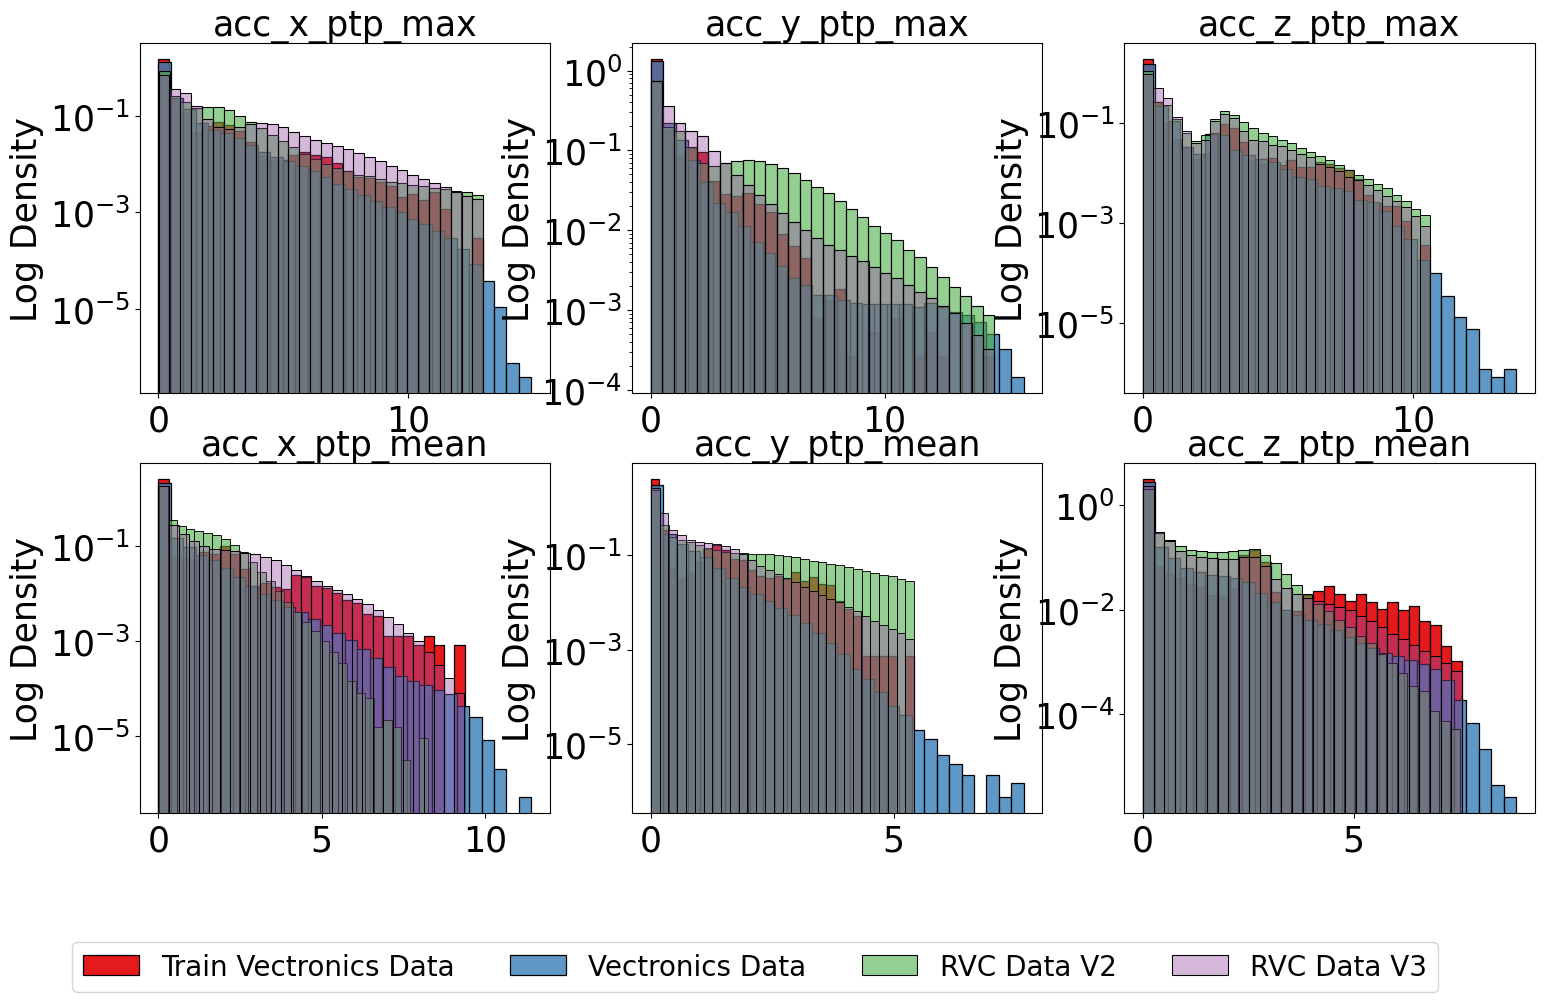

In [12]:
def plot_histograms(X_src, X_src_full, Xt1, Xt2, feature_cols, transform=None, log=True):

    if transform is not None:
        X_src = transform(torch.tensor(X_src, dtype=torch.float32)).numpy()
        X_src_full = transform(torch.tensor(X_src_full, dtype=torch.float32)).numpy()
        Xt1 = transform(torch.tensor(Xt1, dtype=torch.float32)).numpy()
        Xt2 = transform(torch.tensor(Xt2, dtype=torch.float32)).numpy()

    # Plot histograms of features
    fig, axes = plt.subplots(len(feature_cols)//3, 3, figsize=(18, 5*(len(feature_cols)//3)))

    palette = sns.color_palette("Set1", n_colors=4)
    axes = axes.flatten()

    for i, col in enumerate(feature_cols):
            ax = axes[i]

            sns.histplot(
                    X_src[:,i],
                    kde=False,
                    label='Train Vectronics Data',
                    ax=ax,
                    stat='density',
                    bins=30,
                    color=palette[0],
                    alpha=1.0
                )
            
            sns.histplot(
                    X_src_full[:,i],
                    kde=False,
                    label='Vectronics Data',
                    ax=ax,
                    stat='density',
                    bins=30,
                    color=palette[1],
                    alpha=0.8
                )

            sns.histplot(Xt1[:,i],
                    kde=False,
                    label='RVC Data V2',
                    ax=ax,
                    stat='density',
                    bins=30,
                    color=palette[2],
                    alpha=0.6
                )
            sns.histplot(Xt2[:,i],
                    kde=False,
                    label='RVC Data V3',
                    ax=ax,
                    stat='density',
                    bins=30,
                    color=palette[3],
                    alpha=0.4
                )
        
            ax.set_title(col)
            if log:
                ax.set_ylabel('Log Density')
                ax.set_yscale('log')
            else:
                ax.set_ylabel('Density')
            ax.set_xlabel('')

    # Get legend info from the first axes
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(1.5, -1.75), ncol=4)
    plt.show()

plot_histograms(X_src, X_src_full, Xt1, Xt2, Vectronics_feature_cols, transform=None)

The raw feature distributions are highly right-skewed, with most values concentrated near zero and a long tail extending to larger magnitudes. To reduce this skewness, we apply a log1p transformation, which compresses large values while preserving the relative structure of the data.

After the transformation, we normalize all six features to a common range of –1 to 1 to ensure consistent scaling across both source and target domains. This rescaling is implemented using a PyTorch transform object, which standardizes the features before training and evaluation.

In [13]:
# compute global lows/highs once
lows, highs = preprocess.compute_combined_quantiles(
    datasets=[X_src],
    pos_idx=args.pos_idx, 
    center_idx=args.center_idx,
    low_q=0.00,
    high_q=1.00,
)

# define transform
transform = preprocess.TransformAndScale(
    pos_idx=args.pos_idx,
    center_idx=args.center_idx,
    lows=lows,
    highs=highs,
    clip_to_quantile=False
)

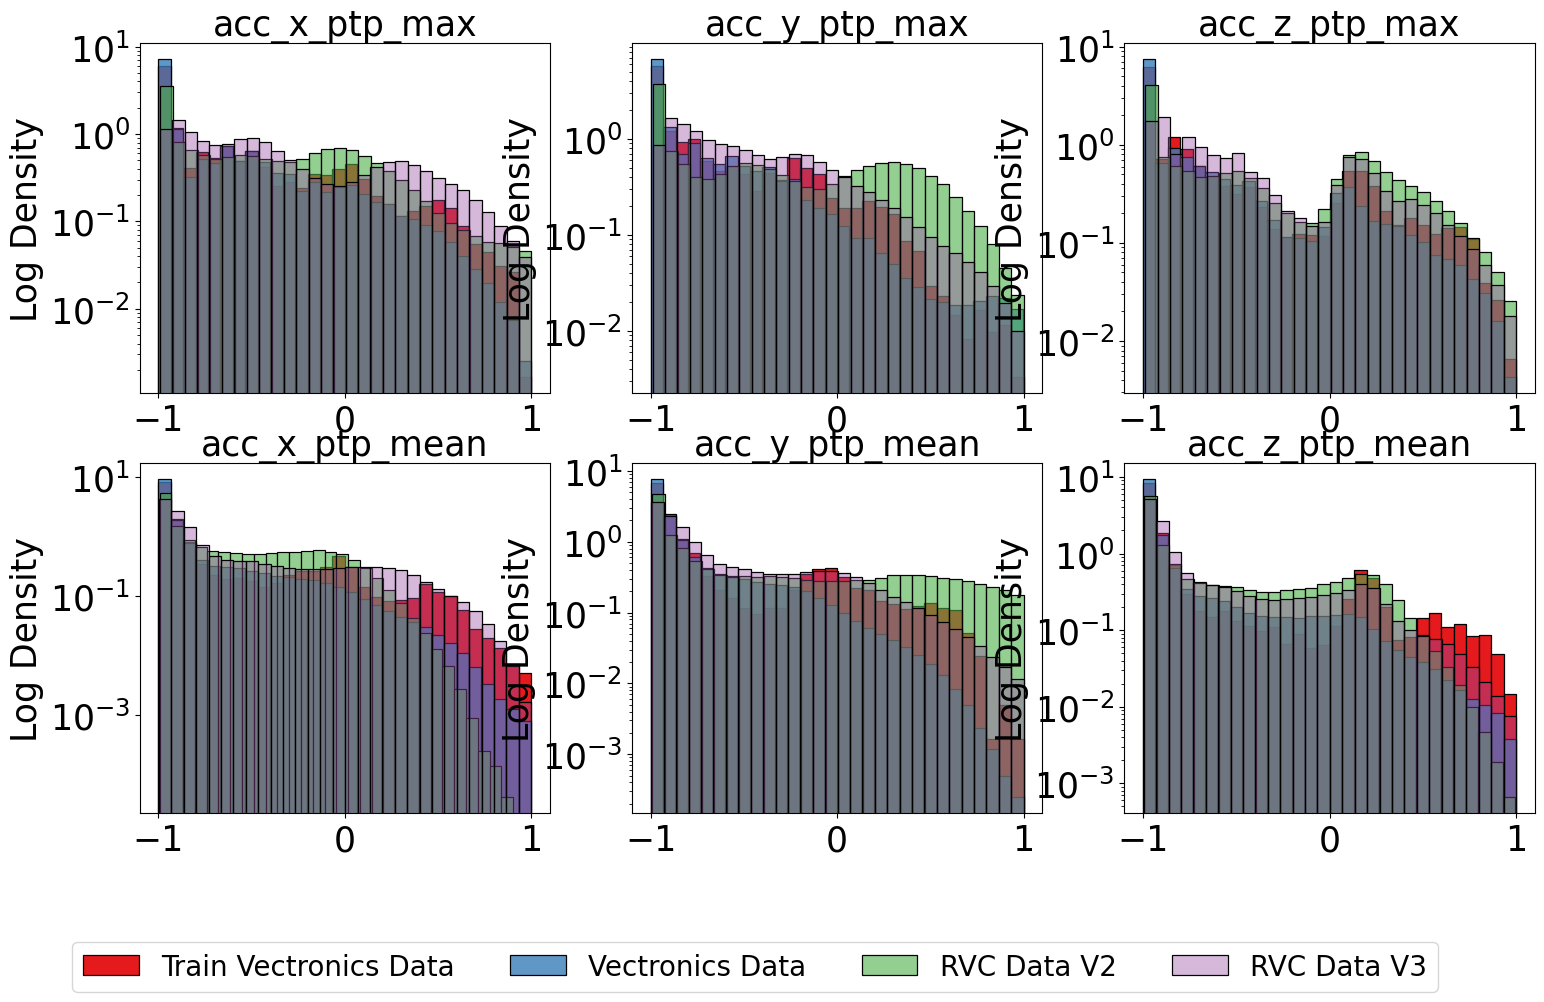

In [31]:
plot_histograms(X_src, X_src_full, Xt1, Xt2, Vectronics_feature_cols, transform=transform)

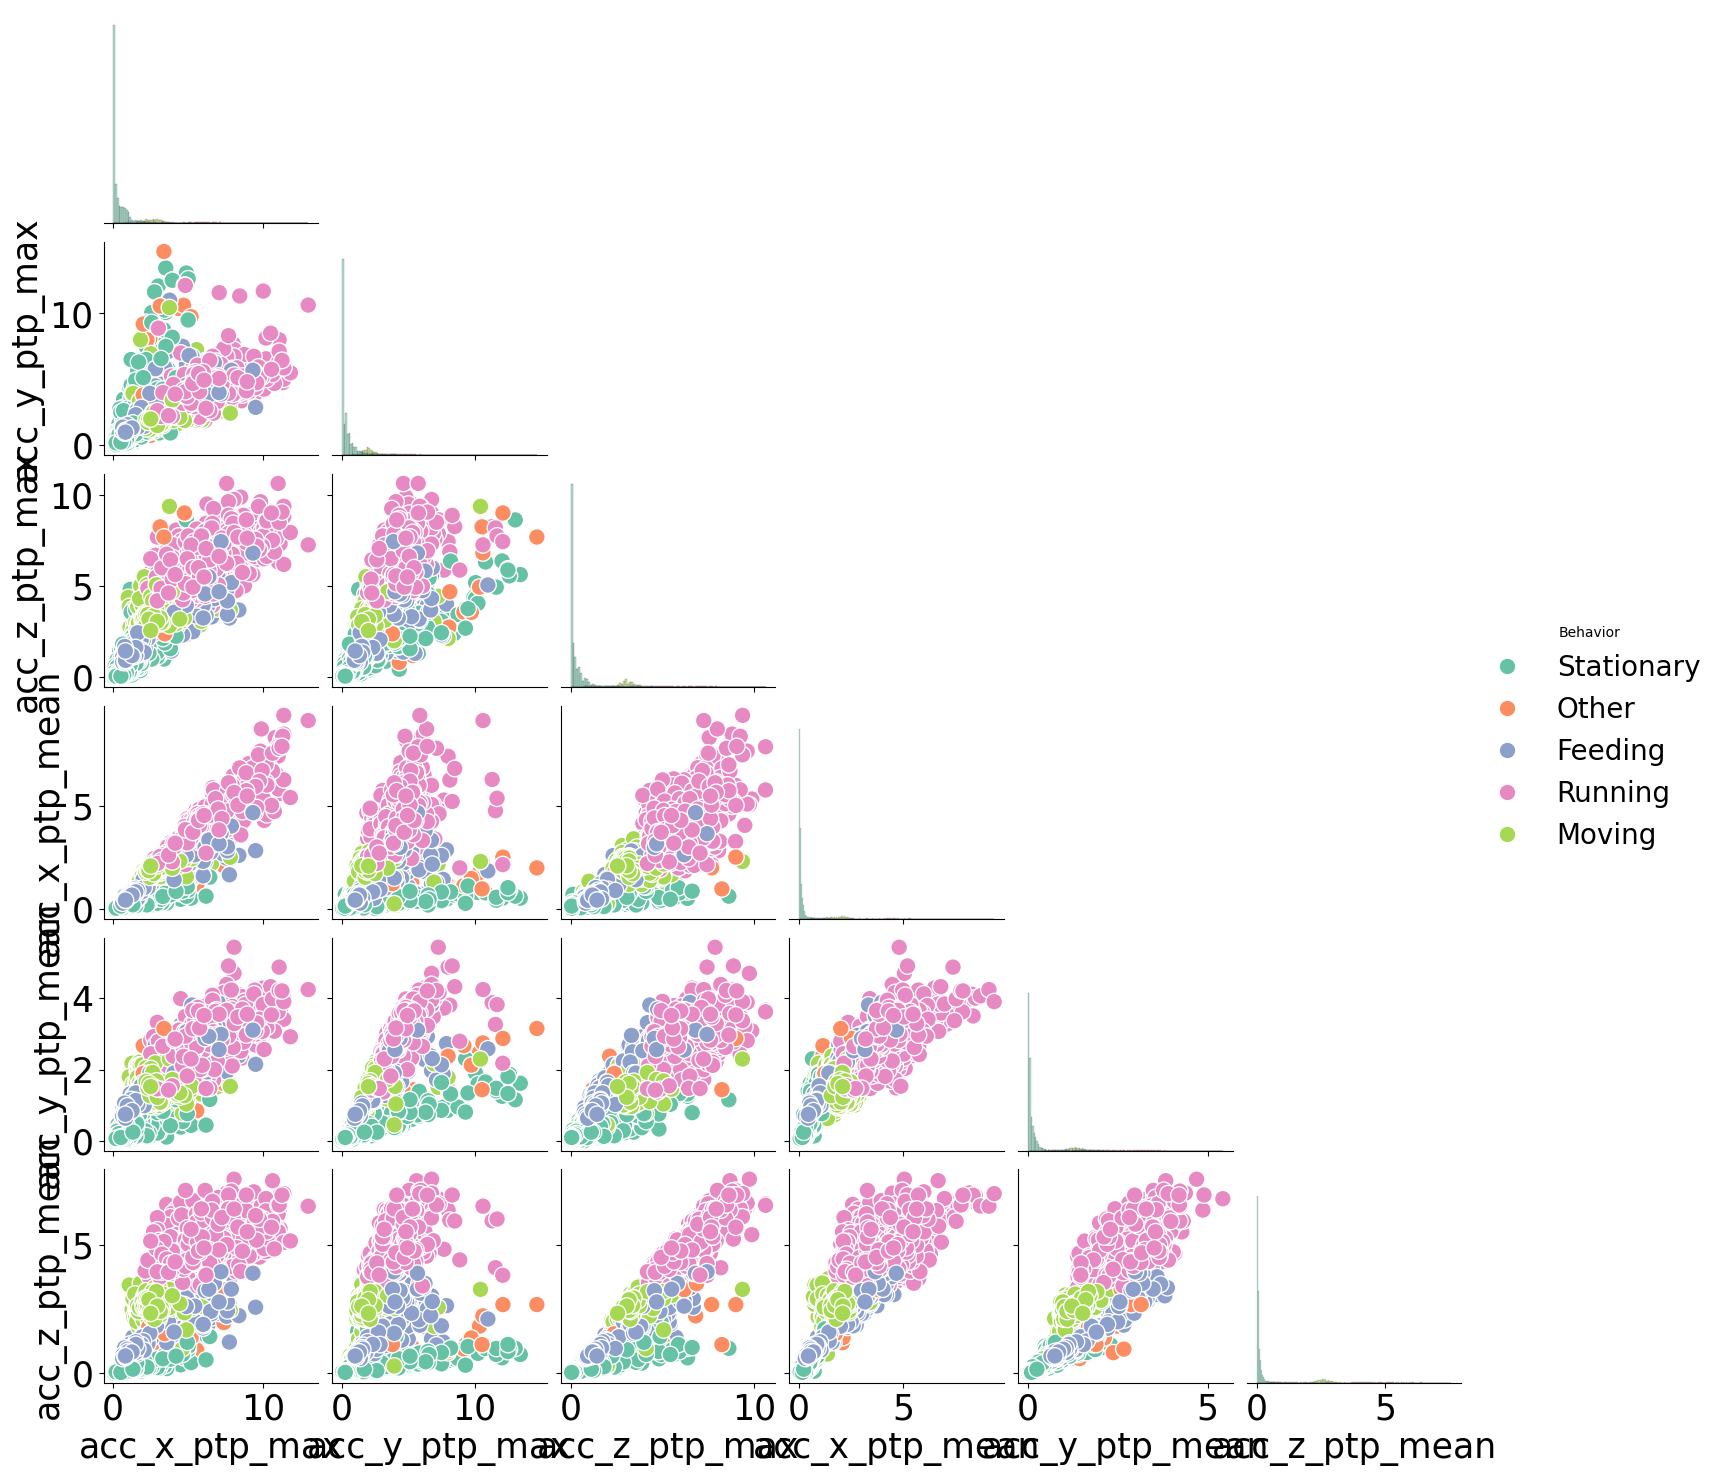

In [37]:
X_df = pd.DataFrame(X_src, columns=Vectronics_feature_cols)
X_df['Behavior'] = label_encoder.inverse_transform(y_src)

sns.pairplot(X_df, hue='Behavior', corner=True, diag_kind='hist', palette='Set2')
plt.show()


### Load Weakly Labeled Target Data on Feeding Days

Next, we load the RVC validation set, which consists of weakly labeled data collected only on days when feeding behavior was observed. We intentionally exclude other days to prevent class imbalance, where resting and movement dominate, and to ensure that feeding behavior remains appropriately represented when selecting the best model parameters.

In [14]:
labeled_mask = RVC_df['behavior'].notna()
RVC_labeled_df = RVC_df[labeled_mask].reset_index(drop=True)

labeled_target_days_with_feeding = []
for i, sensor_version in enumerate(RVC_labeled_df.firmware_major_version.unique().astype(int)):
    df = RVC_labeled_df.loc[(RVC_labeled_df.behavior == 'Feeding') & (RVC_labeled_df.firmware_major_version == sensor_version)].reset_index(drop=True)
    feeding_days = list(df.groupby(['animal_id', 'UTC date [yyyy-mm-dd]']).groups.keys())
    n_feeding_days = len(feeding_days)
    mask = RVC_labeled_df[['animal_id', 'UTC date [yyyy-mm-dd]']].apply(tuple, axis=1).isin(feeding_days)
    X_t, y_t = RVC_labeled_df[mask][Vectronics_feature_cols].values, RVC_labeled_df[mask]['behavior'].values
    y_t = label_encoder.transform(y_t)
    labeled_target_days_with_feeding.append((X_t, y_t))

print("LABELED TARGET DATA WITH FEEDING")
for i, (X_t, y_t) in enumerate(labeled_target_days_with_feeding):
    classes, counts = np.unique(y_t, return_counts=True)
    print(f"Target {i+1}:")
    print(f"Total observations: {X_t.shape[0]}")
    print(f"Class distribution:")
    for cls, count in zip(classes, counts):
        print(f" - {cls}: {count}, ({count / X_t.shape[0]:.2%})")
    print("")

LABELED TARGET DATA WITH FEEDING
Target 1:
Total observations: 24555
Class distribution:
 - 0: 1175, (4.79%)
 - 1: 9410, (38.32%)
 - 4: 13970, (56.89%)

Target 2:
Total observations: 13008
Class distribution:
 - 0: 323, (2.48%)
 - 1: 4990, (38.36%)
 - 4: 7695, (59.16%)



## STEP 2. Training Models

We train two independent **FixMatch** domain-adaptation models to account for the differences between the two sensor versions in the target RVC data.

* **Model 1:** Adapts from Vectronics (Source) to RVC Sensor Version **2.0** (Target 1).
* **Model 2:** Adapts from Vectronics (Source) to RVC Sensor Version **3.0** (Target 2).

**The training takes 6.5 minutes.** 

In [15]:
args.input_dim = X_src.shape[-1]
args.n_classes = len(label_encoder.classes_)

### Creating Dataloaders for Training

The dataloader performs two key operations during batch construction:

* **Transforms:** Applies the defined `transform` to each batch to ensure consistent preprocessing.
* **Dynamic class rebalancing:** Adjusts the class composition of each batch using the `args.theta` parameter, achieving the desired class distribution through controlled under- and oversampling.
 batch via under and oversampling.

In [16]:
n_classes = len(label_encoder.classes_)
X_train, X_temp, y_train, y_temp = train_test_split(X_src, y_src, test_size=2*args.test_frac, random_state=42, stratify=y_src)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
train_loader, val_loader, test_loader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args, n_outputs=n_classes, transform=transform)
print("SOURCE DATA SPLITS")
print(f"Train data: {X_train.shape}")
print(f"Val data: {X_val.shape}")
print(f"Test data: {X_test.shape}")
print("")

target_train_loaders = []
target_test_loaders = []

for i, Xt in enumerate([Xt1, Xt2]):

    idx = np.random.permutation(len(Xt))
    target_train_idx = idx[:X_train.shape[0]]
    target_test_idx = idx[X_train.shape[0]:]  # remaining go to test

    X_target_train, X_target_test = Xt[target_train_idx], Xt[target_test_idx]

    # Build target train/test datasets
    target_train_dataset = datasets.NumpyDataset(X=X_target_train, y=None, transform=transform)
    target_test_dataset  = datasets.NumpyDataset(X=X_target_test, y=None, transform=transform)

    # Create loaders
    target_train_loader = DataLoader(target_train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True)
    target_test_loader  = DataLoader(target_test_dataset,  batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True)

    target_train_loaders.append(target_train_loader)
    target_test_loaders.append(target_test_loader)
    
    print(f"TARGET-{i+1} DATA SPLITS")
    print(f"Train data: {X_target_train.shape}")
    print(f"Test data: {X_target_test.shape}")
    print("")

SOURCE DATA SPLITS
Train data: (4623, 6)
Val data: (1541, 6)
Test data: (1542, 6)

TARGET-1 DATA SPLITS
Train data: (4623, 6)
Test data: (1204789, 6)

TARGET-2 DATA SPLITS
Train data: (4623, 6)
Test data: (4394302, 6)



In [ ]:
for i, loader in enumerate(target_train_loaders):

    print(f"Training CORAL for target domain {i+1}...")

    # ---------------- Train CORAL ----------------
    results = train_coral(train_loader, val_loader, test_loader, loader, args, device)
    model = results['model']

    # ----------- Save Training Objects -----------
    dir = os.path.join(root_dir, f'target{i+1}')
    os.makedirs(dir, exist_ok=True)

    # (1) save model
    torch.save(model.state_dict(), os.path.join(dir, 'model.pt'))

    # save training statistics
    json_training_stats_file = os.path.join(dir, 'training_stats.json')
    with open(json_training_stats_file, 'w') as f:
        json.dump(results['training_stats'], f, indent=4)

    # (2) save test results
    test_results_path = os.path.join(dir, 'test_results.npz')
    np.savez(
    test_results_path,
    true_classes=results['test_true_classes'],
    predictions=results['test_predictions'],
    scores=results['test_scores'])

    # (3) save validation results
    val_results_path = os.path.join(dir, 'val_results.npz')
    np.savez(
        val_results_path,
        true_classes=results['val_true_classes'],
        predictions=results['val_predictions'],
        scores=results['val_scores'])
    
    # ----------- Evaluation -----------

    # evaluate label distribution on target test set
    _, _, _ = evaluate_multilabel_distribution(model=model, 
                                        data=target_test_loaders[i],
                                        label_encoder=label_encoder,
                                        device=device, 
                                        threshold=0.5,
                                        verbose=True)
    
    print(f"Finished training and evaluation for target domain {i+1}.\n")
    print(f"----------------------------------------\n")
    print(f'Results saved to {dir}\n')

## STEP 3. Model Evaluation

The evaluation focuses on two main areas: test-set performance and distribution analysis.

* The model is evaluated on the held-out test sets from both the **source domain** (Sensor 1 and Sensor 2) and a **Confusion Matrix** is generated for each target domain's labeled test set.

* The label distribution is predicted for the entire (labeled & unlabaled) source and target data.

* The **Receiver Operating Characteristic (ROC) curve** and **Area Under the Curve (AUC)** are computed for the multi-class classification task.


In [18]:
# Alternatively, specify the "root_dir" here to visualize results from a saved model run.

root_dir = "/home/medhaaga/BotswanaML/results/domain_adaptation_training_results/coral/DEFAULT_2025-12-17_23-52-16"

#### (1) Confusion matrices

Plotting confusion matrices for the two models on held-out validation set of the source data.

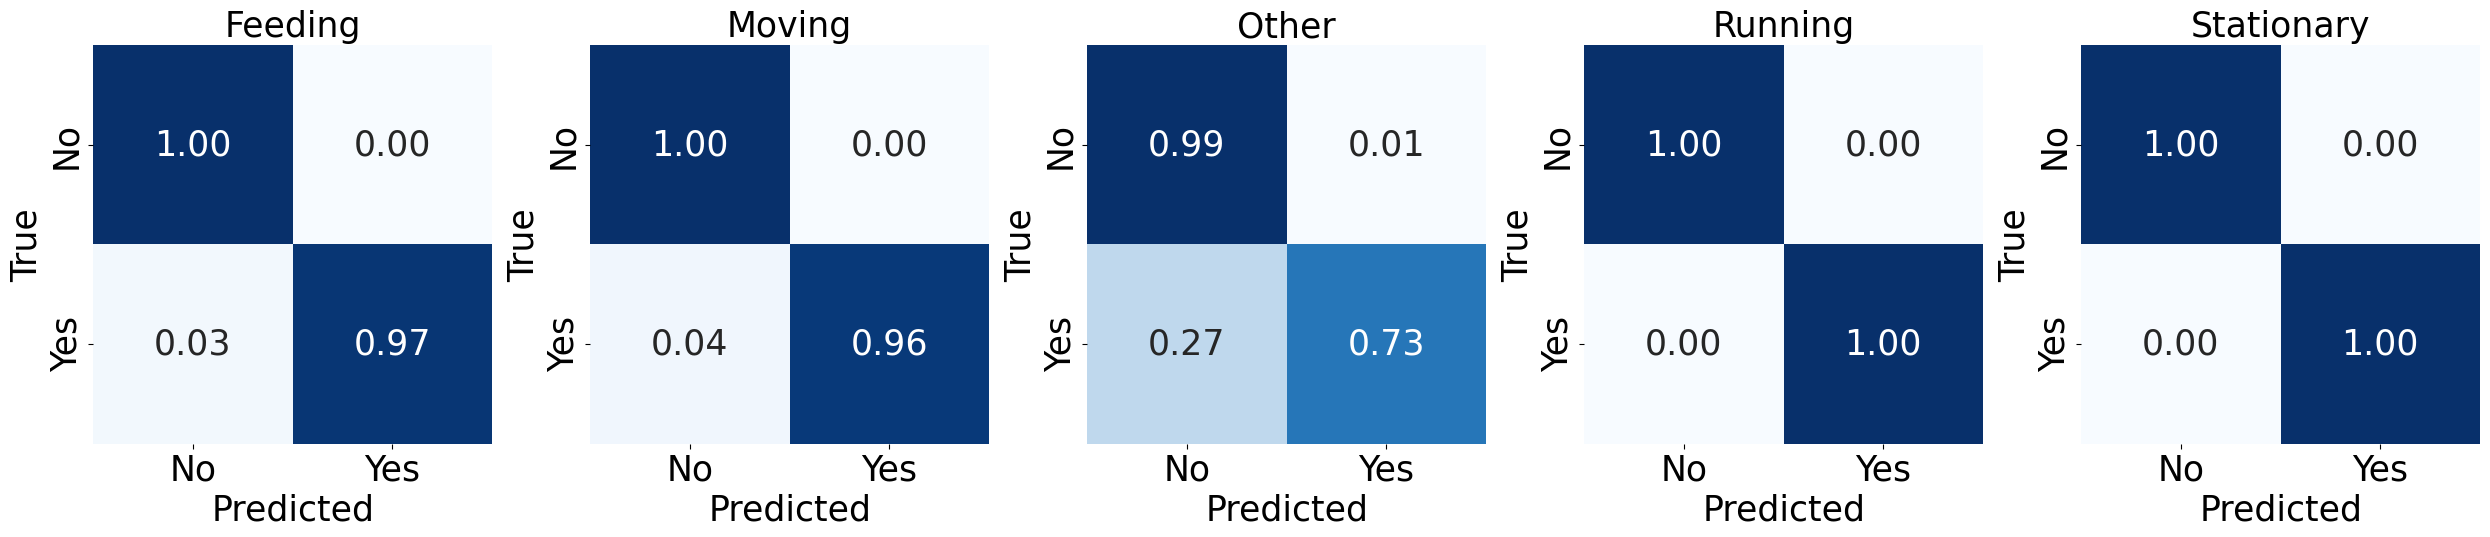

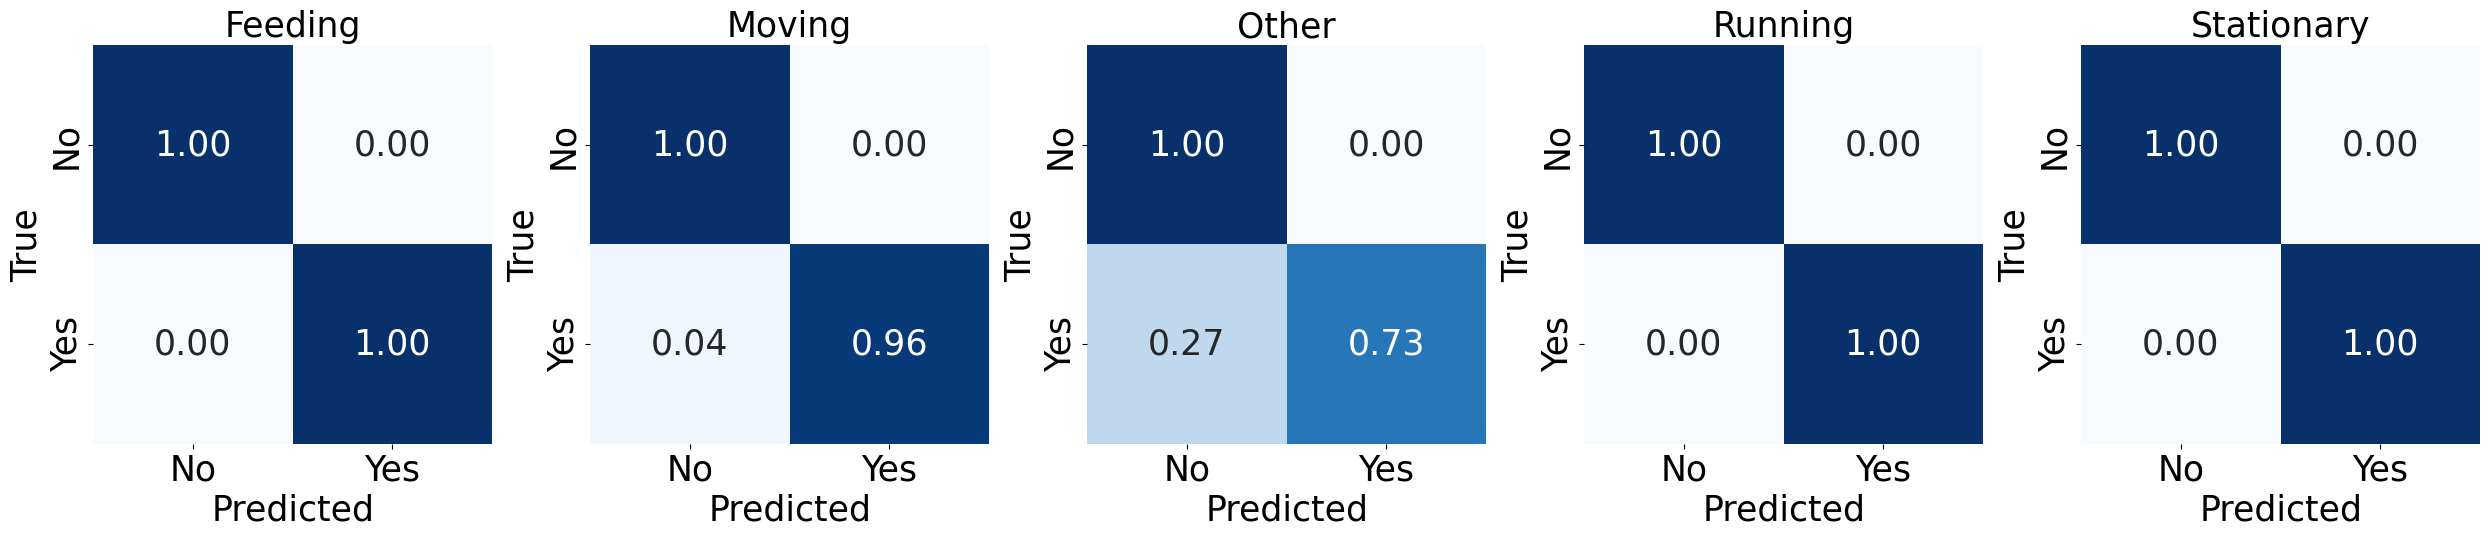

{}

In [19]:
dir1 = os.path.join(root_dir, "target1")
dir2 = os.path.join(root_dir, "target2")

multi_label_predictions(dir1, label_encoder, split='test', plot_confusion=True, return_precision=False)
multi_label_predictions(dir2, label_encoder, split='test', plot_confusion=True, return_precision=False)

Plotting confusion matrices for the two models on the entire (weakly) labeled target data belong to the respective sensor version.

/tmp/ipykernel_1647754/424694080.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(dir_path, 'model.pt'), map_location=device)


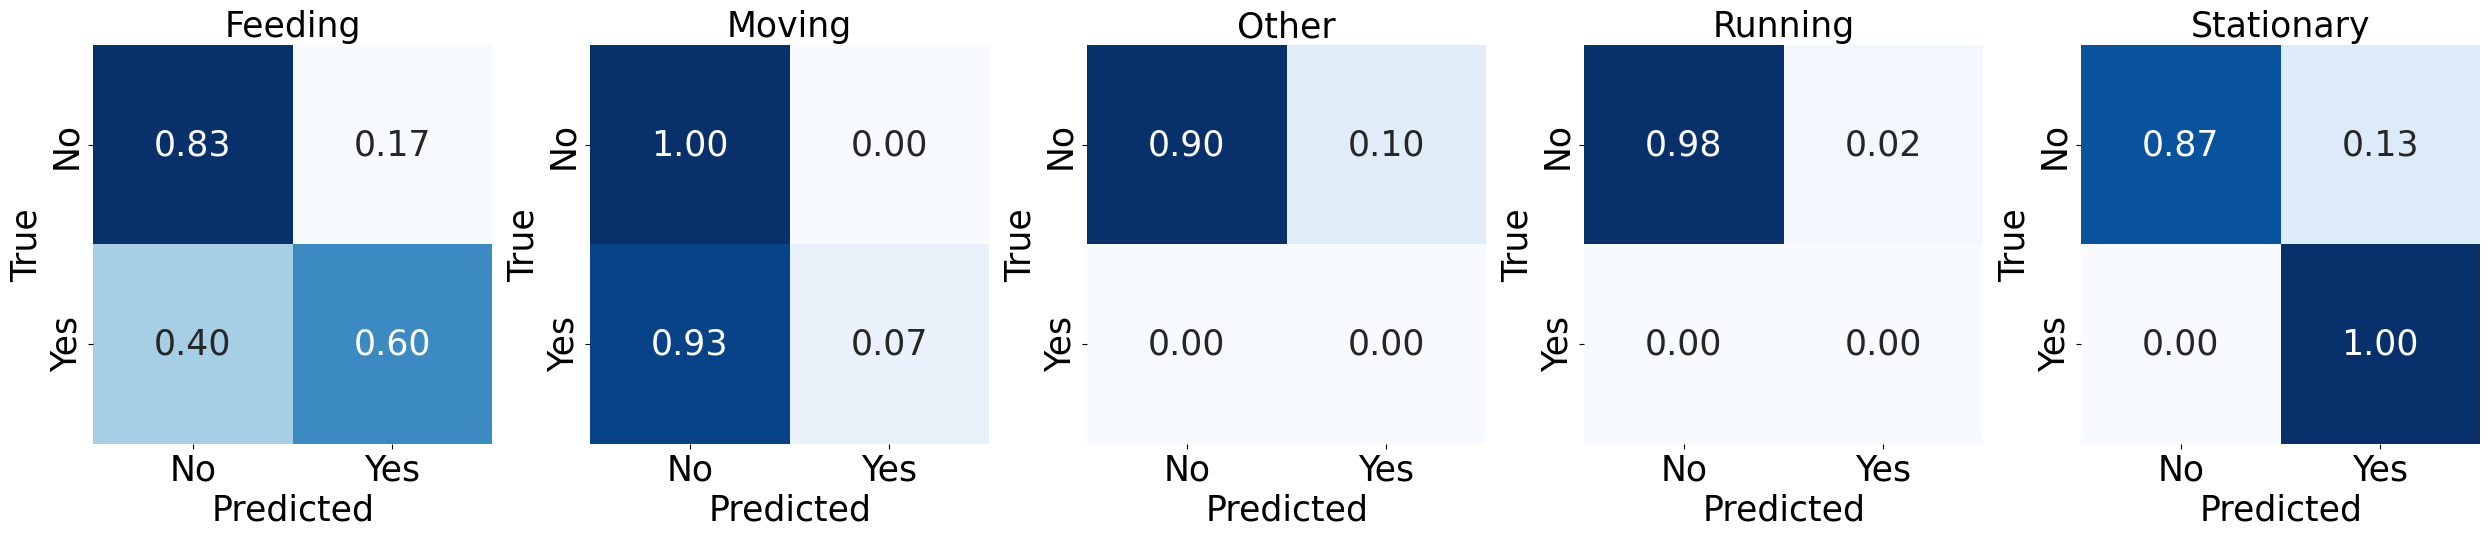

/tmp/ipykernel_1647754/424694080.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(dir_path, 'model.pt'), map_location=device)


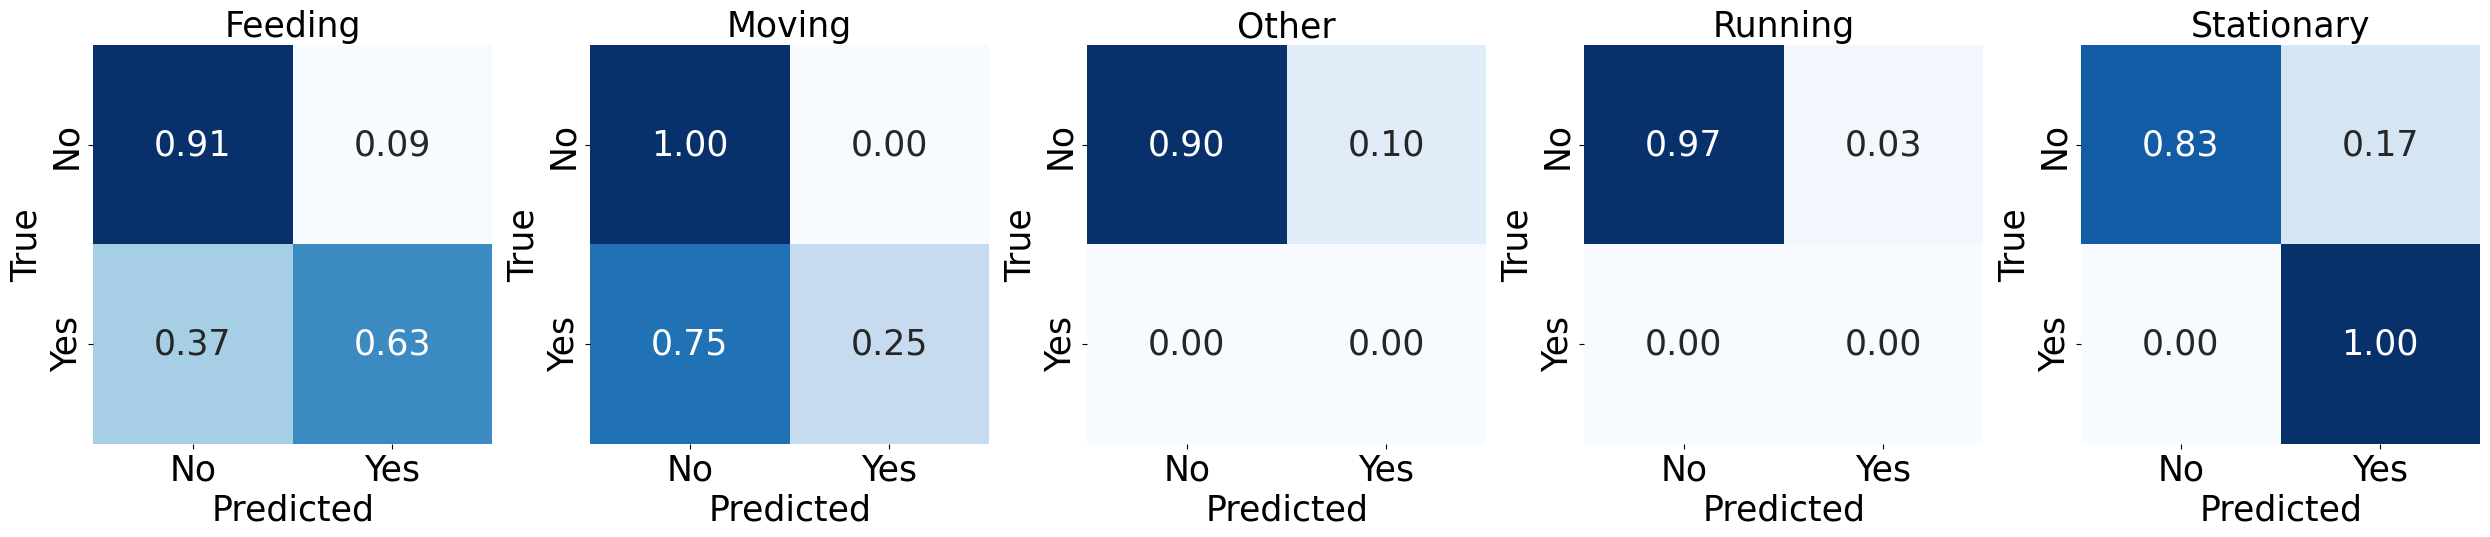

In [25]:
for i, dir_path in enumerate([dir1, dir2]):
    
    coral_model = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
    coral_model.load_state_dict(
        torch.load(os.path.join(dir_path, 'model.pt'), map_location=device)
    )
    coral_model.to(device)

    mask_fw = (RVC_labeled_df.firmware_major_version == (i+2))
    Xt = transform(torch.tensor(RVC_labeled_df.loc[mask_fw, Vectronics_feature_cols].values, dtype=torch.float32))
    yt = RVC_labeled_df.loc[mask_fw, 'behavior'].values
    yt = np.eye(len(label_encoder.classes_))[label_encoder.transform(yt)]

    with torch.no_grad():
        _, logits = coral_model(Xt.to(device))
        preds = torch.sigmoid(logits).detach().cpu().numpy()
        preds = (preds >= 0.5).astype(int)

    # Confusion matrices
    make_multilabel_confusion_matrices(
        y_true=yt, 
        y_pred=preds,
        label_encoder=label_encoder
    )



#### (2) Label Distribution

In [ ]:
for i, dir_path in enumerate([dir1, dir2]):
    coral_model = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
    coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    coral_model.to(device)
    print(f"Evaluating FixMatch model for target domain {i+1}...")

    print("PREDICTED SOURCE LABEL DISTRIBUTION:")
    all_pred_binary, all_probs, predicted_percent = evaluate_multilabel_distribution(model=coral_model, 
                                data=transform(torch.tensor(X_src_full, dtype=torch.float32)),
                                label_encoder=label_encoder,
                                device=device, 
                                threshold=0.5)

    Xt = RVC_df.loc[RVC_df.firmware_major_version == (i+2)][Vectronics_feature_cols].values
    print("PREDICTED TARGET LABEL DISTRIBUTION:")
    _, _, _ = evaluate_multilabel_distribution(model=coral_model, 
                                    data=transform(torch.tensor(Xt, dtype=torch.float32)), 
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)    

#### (3) ROC Curve


/tmp/ipykernel_1647754/3482014813.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location

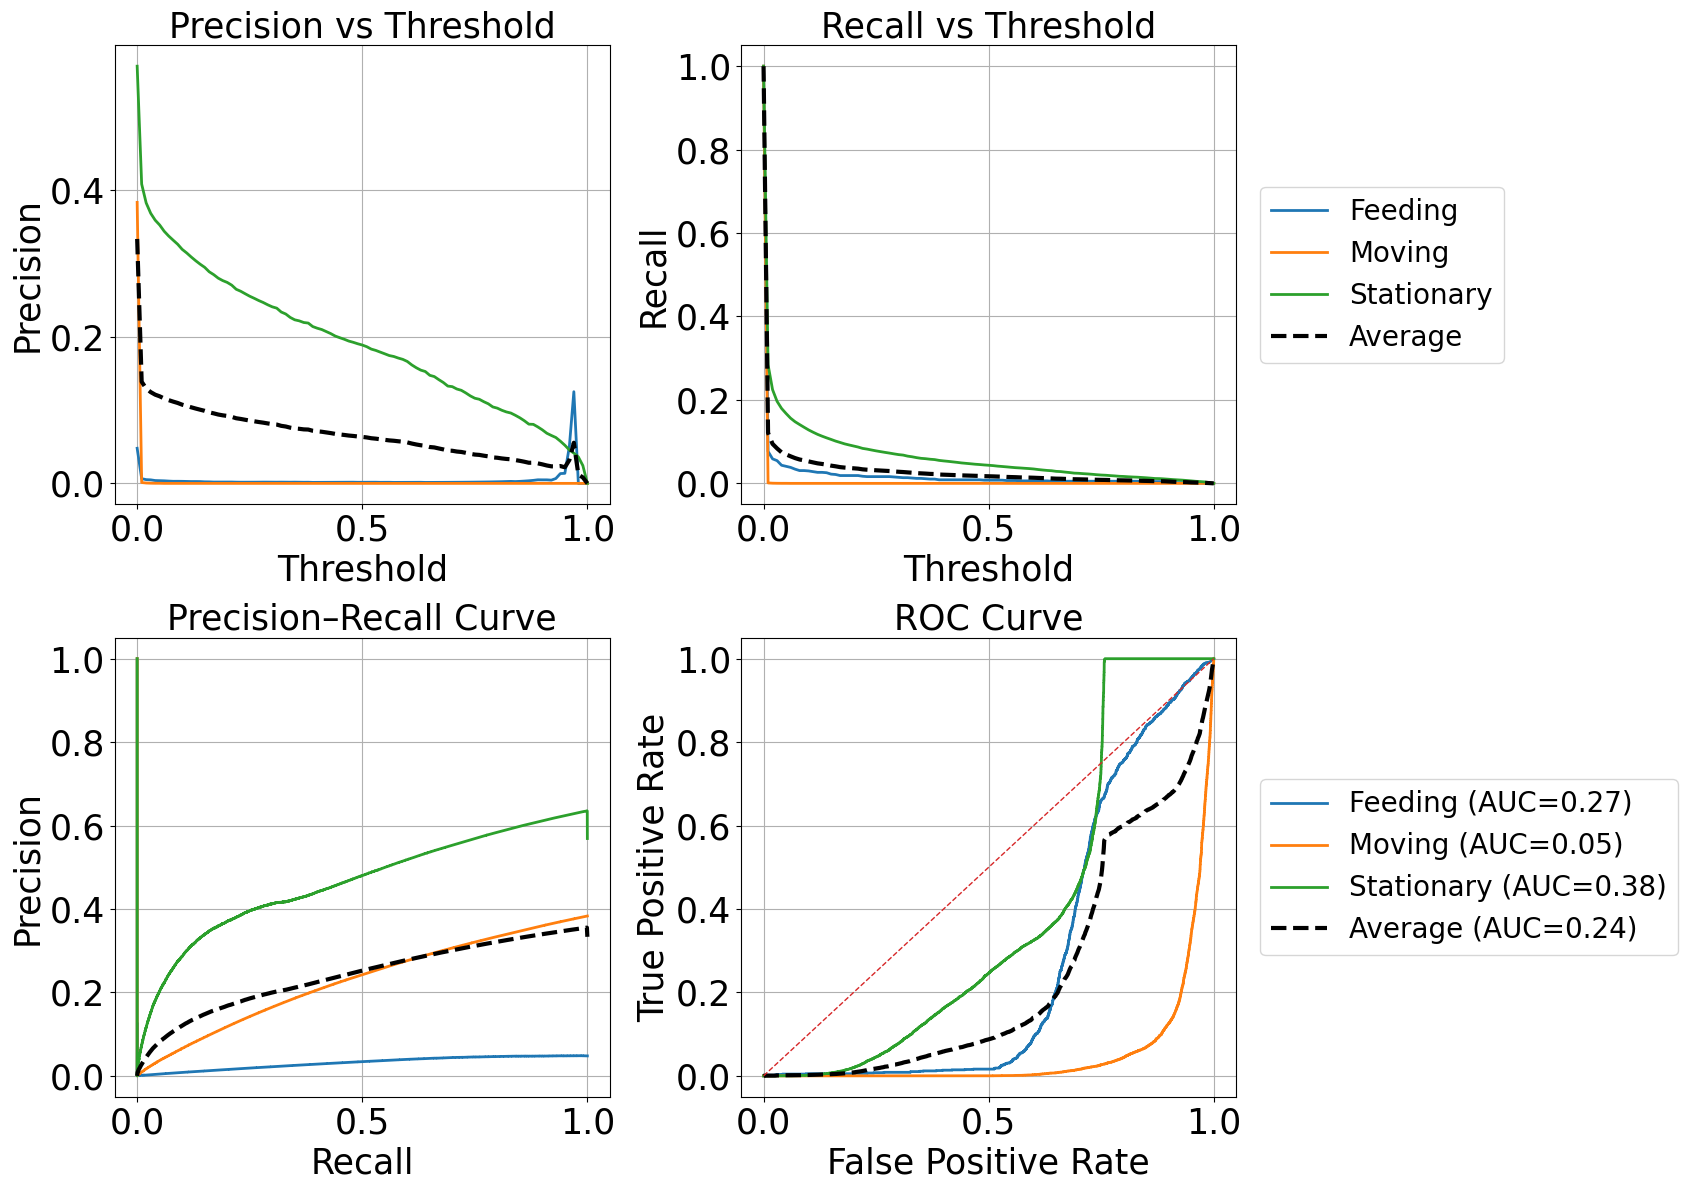

/tmp/ipykernel_1647754/3482014813.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location

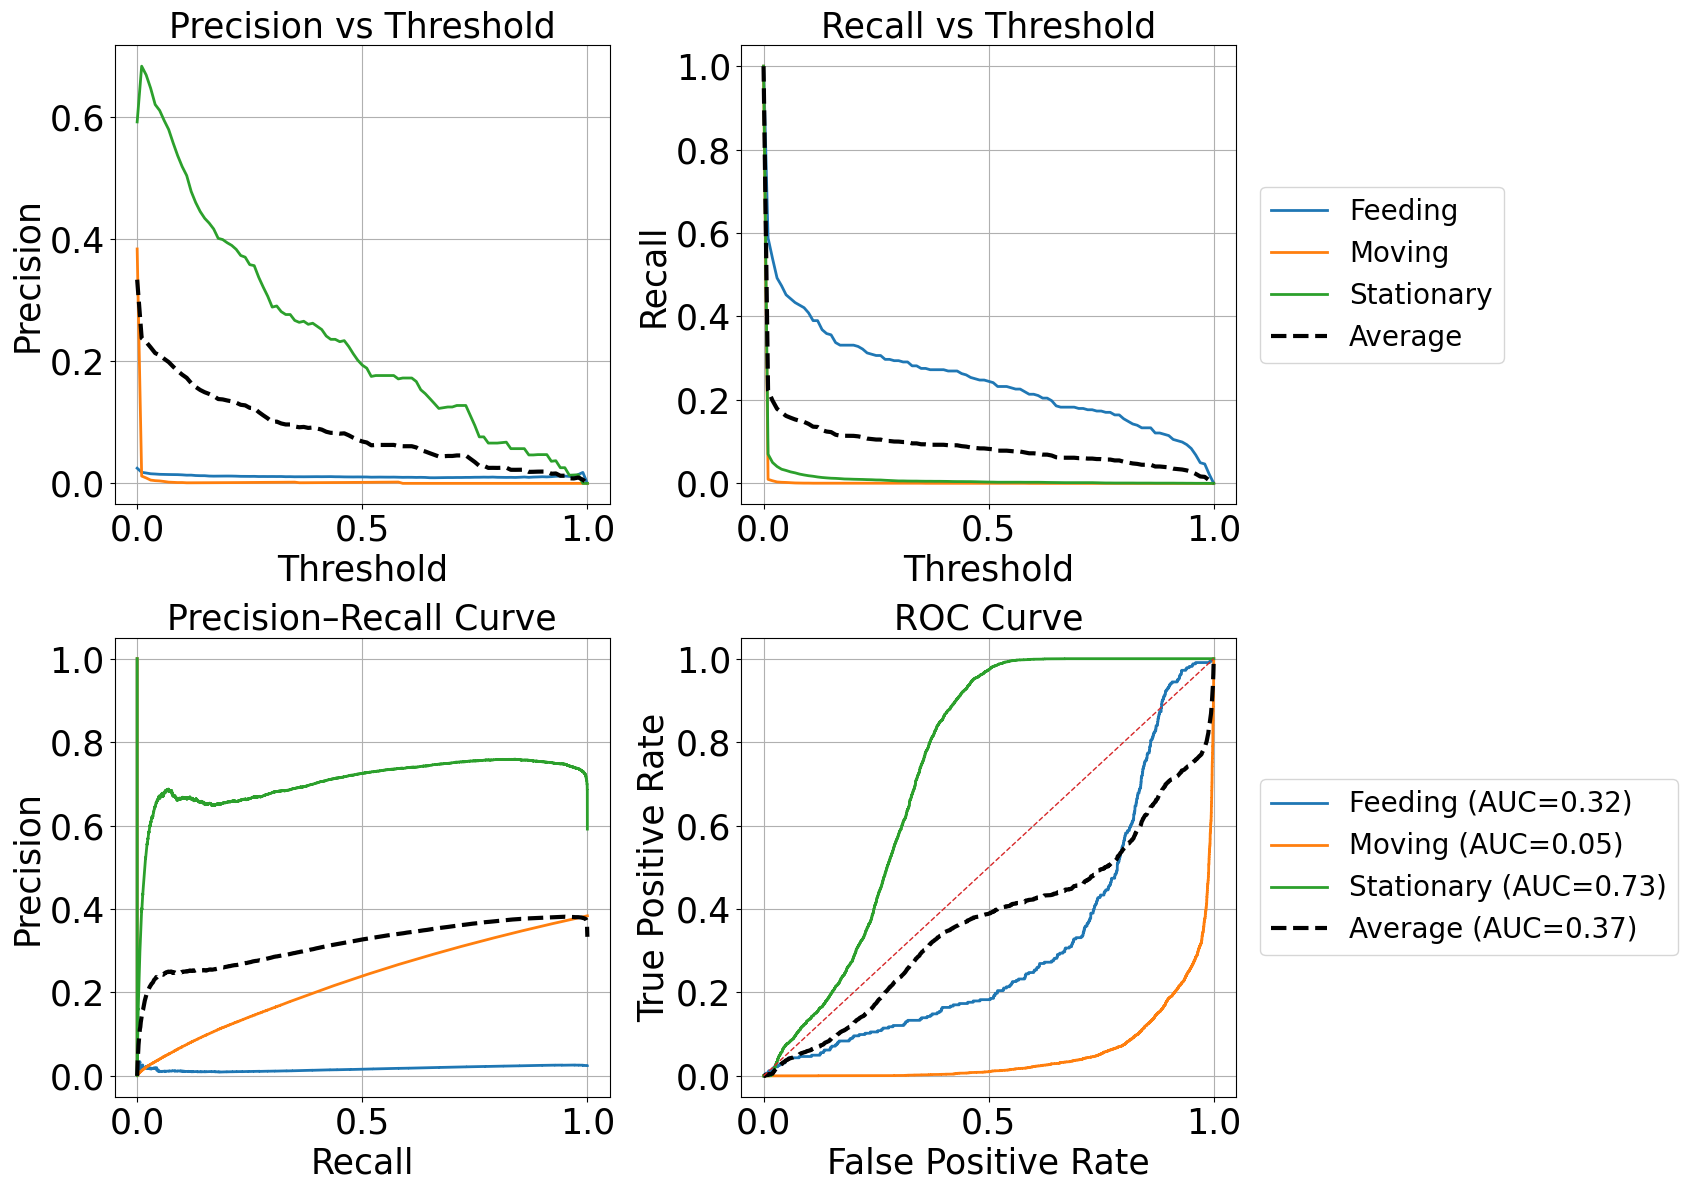

In [27]:
for i, dir_path in enumerate([dir1, dir2]):
    coral_model = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
    coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    coral_model.to(device)

    with torch.no_grad():
        _, logits = coral_model(torch.tensor(labeled_target_days_with_feeding[i][0], dtype=torch.float32).to(device))
        predictions = torch.sigmoid(logits).detach().cpu().numpy()

    plot_multiclass_threshold_diagnostics(labeled_target_days_with_feeding[i][1], predictions, label_encoder=label_encoder)

## STEP 4. Calibration

To correct the observed miscalibration, we apply a post-hoc **calibration procedure** that adjusts the predicted scores to match an ecologically reasonable **"golden" reference label distribution**.

### Calibration Procedure

1.  **Clustering:** K-Means clustering is performed on the target features to identify distinct feature regions, creating **$N=100$ clusters**.
2.  **Model Scoring:** The pre-trained FixMatch model scores are computed for the centroid of each cluster.
3.  **Distribution Alignment:** A calibration matrix is computed to adjust the cluster scores to align with a user-defined *ecological prior* (`label_dist`).

The user-defined "golden" label distribution used for calibration (representing an ecologically realistic prior) is:

$$\text{label\_dist} = [2.55, 4.48, 3.55, 1.96, 87.45]\%$$

*(Feeding, Moving, Other, Running, Stationary)*


In [40]:
Xt1 = transform(torch.tensor(RVC_df.loc[RVC_df.firmware_major_version == 2][Vectronics_feature_cols].values, dtype=torch.float32))
Xt2 = transform(torch.tensor(RVC_df.loc[RVC_df.firmware_major_version == 3][Vectronics_feature_cols].values, dtype=torch.float32))

uncalibrated_predictions = []
for i, (Xt, dir_path) in enumerate([(Xt1, dir1), (Xt2, dir2)]):

    coral_model = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
    coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    coral_model.to(device)
    
    with torch.no_grad():
        print(f"Evaluating FixMatch model for target domain {i+1}...")
        _, logits = coral_model(Xt.to(device))
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        pred_df = pd.DataFrame(probs, columns=label_encoder.classes_)

    df = pd.concat(
        [RVC_df.loc[RVC_df.firmware_major_version == 2+i].reset_index(drop=True),
         pred_df.reset_index(drop=True)],
        axis=1
    )
    
    uncalibrated_predictions.append(df)
    
uncalibrated_predictions = pd.concat(uncalibrated_predictions, axis=0).reset_index(drop=True).sort_values(by=['animal_id', 'UTC time [yyyy-mm-dd HH:MM:SS]']).reset_index(drop=True)

/tmp/ipykernel_1647754/334624397.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=

Evaluating FixMatch model for target domain 1...


/tmp/ipykernel_1647754/334624397.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=

Evaluating FixMatch model for target domain 2...


In [41]:
N_CLUSTERS, CLUSTER_BATCH_SIZE = 100, 1024
reg = 0.01

cluster_dist1, cluster_centroids1, cluster_labels1, kmeans1 = func.compute_kmeans_distribution(Xt1, 
                                                                                               n_clusters=N_CLUSTERS, 
                                                                                               batch_size=CLUSTER_BATCH_SIZE, 
                                                                                               random_state=42)
cluster_dist2, cluster_centroids2, cluster_labels2, kmeans2 = func.compute_kmeans_distribution(Xt2, 
                                                                                               n_clusters=N_CLUSTERS, 
                                                                                               batch_size=CLUSTER_BATCH_SIZE, 
                                                                                               random_state=42)
label_dist = np.array([2.55, 4.48, 3.55, 1.96, 87.45])

In [30]:
coral_model1 = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
coral_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=device))
coral_model1.to(device)

coral_model2 = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
coral_model2.to(device)

calibration1_results = calibration(cluster_dist1, cluster_centroids1, cluster_labels1, coral_model1, label_dist=label_dist, reg=reg)
calibration2_results = calibration(cluster_dist2, cluster_centroids2, cluster_labels2, coral_model2, label_dist=label_dist, reg=reg)

calibrated_predictions = []
adjusted_scores1 = calibration1_results['adjusted_scores'][cluster_labels1]
df = pd.concat(
        [RVC_df.loc[RVC_df.firmware_major_version == 2].reset_index(drop=True),
         pd.DataFrame(adjusted_scores1, columns=label_encoder.classes_).reset_index(drop=True)],
        axis=1
    )
calibrated_predictions.append(df)

adjusted_scores2 = calibration2_results['adjusted_scores'][cluster_labels2]
df = pd.concat([RVC_df.loc[RVC_df.firmware_major_version == 3].reset_index(drop=True),
         pd.DataFrame(adjusted_scores2, columns=label_encoder.classes_).reset_index(drop=True)],
        axis=1)
calibrated_predictions.append(df)
calibrated_predictions = pd.concat(calibrated_predictions, axis=0).reset_index(drop=True).sort_values(by=['animal_id', 'UTC time [yyyy-mm-dd HH:MM:SS]']).reset_index(drop=True)


/tmp/ipykernel_1647754/2872115064.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=de

/tmp/ipykernel_1647754/1547002931.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location

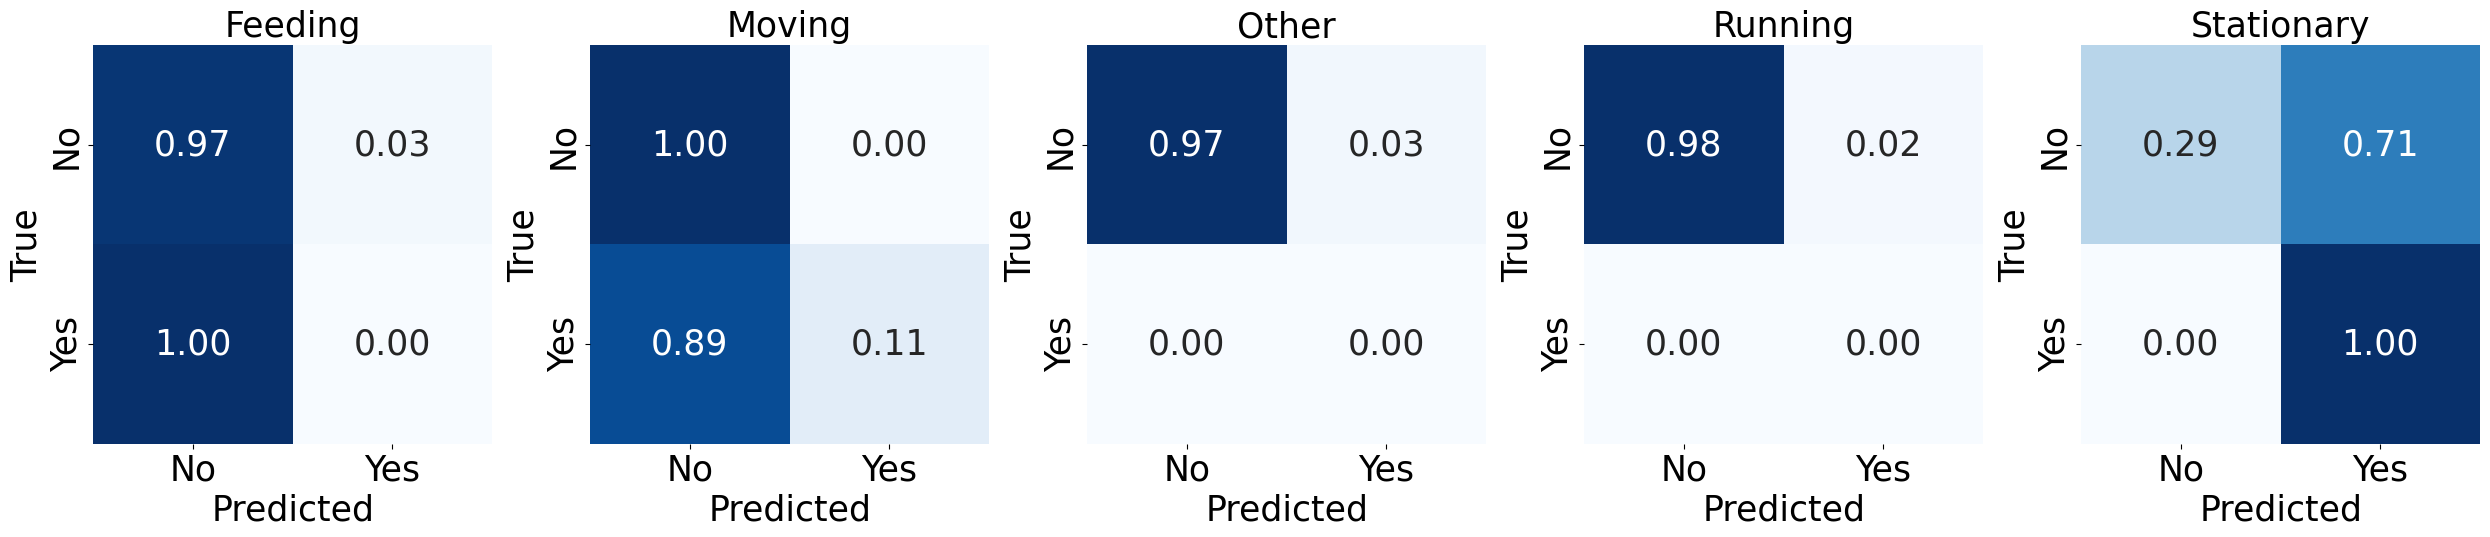

/tmp/ipykernel_1647754/1547002931.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location

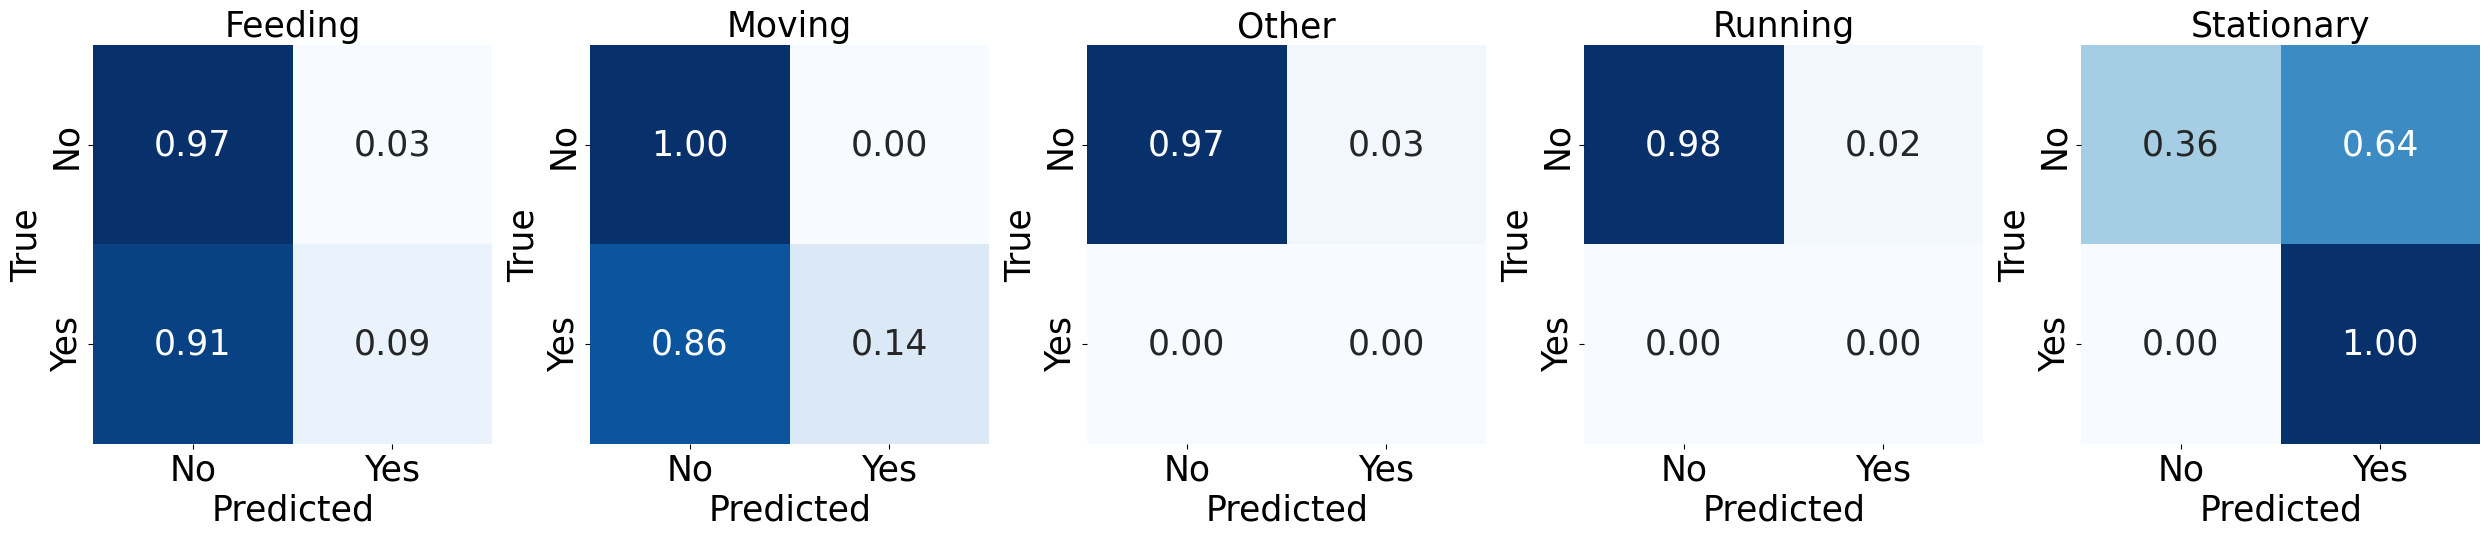

In [31]:
for i, dir_path in enumerate([dir1, dir2]):
    coral_model = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
    coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    coral_model.to(device)
    
    Xt, yt = RVC_labeled_df.loc[RVC_labeled_df.firmware_major_version == (i+2)][Vectronics_feature_cols].values, RVC_labeled_df.loc[RVC_labeled_df.firmware_major_version == (i+2)]['behavior'].values
    Xt = transform(torch.tensor(Xt, dtype=torch.float32))
    yt = np.eye(len(label_encoder.classes_))[label_encoder.transform(yt)]

    cluster_labels = kmeans1.predict(Xt) if i==0 else kmeans2.predict(Xt)
    adjusted_scores = calibration1_results['adjusted_scores'][cluster_labels] if i==0 else calibration2_results['adjusted_scores'][cluster_labels]
    predictions = (adjusted_scores >= 0.5).astype(int)
    make_multilabel_confusion_matrices(y_true=yt, 
                                    y_pred=predictions,
                                    label_encoder=label_encoder)



Creating the following plots takes **~10 minutes** because of the size of RVC data.

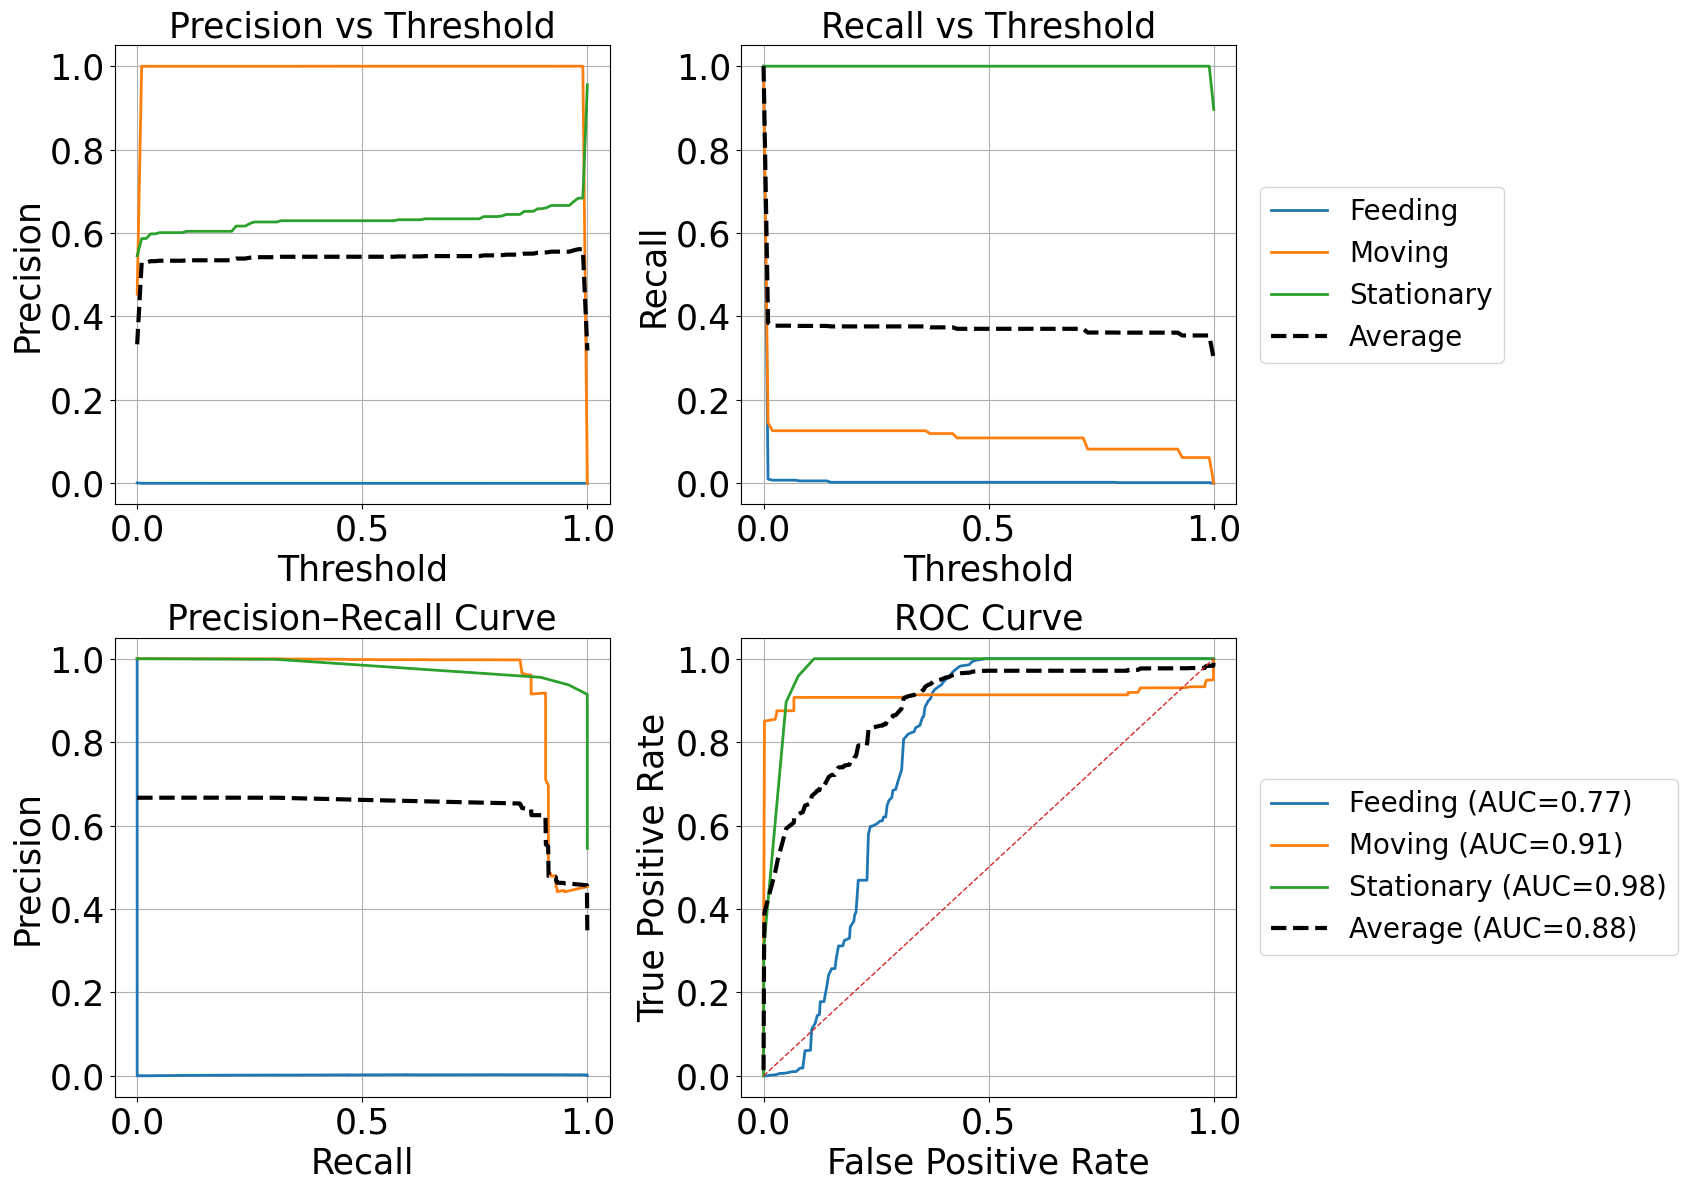

KeyboardInterrupt: 

In [32]:
for i, _ in enumerate([dir1, dir2]):
    
    Xt, yt = RVC_labeled_df.loc[RVC_labeled_df.firmware_major_version == (i+2)][Vectronics_feature_cols].values, RVC_labeled_df.loc[RVC_labeled_df.firmware_major_version == (i+2)]['behavior'].values
    Xt = transform(torch.tensor(Xt, dtype=torch.float32))
    yt = label_encoder.transform(yt)

    cluster_labels = kmeans1.predict(Xt) if i==0 else kmeans2.predict(Xt)
    adjusted_scores = calibration1_results['adjusted_scores'][cluster_labels] if i==0 else calibration2_results['adjusted_scores'][cluster_labels]
    plot_multiclass_threshold_diagnostics(yt, adjusted_scores, label_encoder=label_encoder)

## STEP 5. Prediction and saving outputs

Saving the uncalibrated and calibrated prediction scores for each target distribution.

In [ ]:
uncalibrated_predictions['behavior_pred'] = (uncalibrated_predictions[label_encoder.classes_].values.argmax(axis=1))
uncalibrated_predictions['behavior_pred'] = label_encoder.inverse_transform(uncalibrated_predictions['behavior_pred'])
uncal_path = os.path.join(os.path.dirname(dir1), 'RVC_predictions_uncalibrated.csv')
uncalibrated_predictions.to_csv(uncal_path, index=False)
print(f"Saved concatenated uncalibrated predictions: {uncal_path}")

calibrated_predictions['behavior_pred'] = (calibrated_predictions[label_encoder.classes_].values.argmax(axis=1))
calibrated_predictions['behavior_pred'] = label_encoder.inverse_transform(calibrated_predictions['behavior_pred'])
cal_path = os.path.join(os.path.dirname(dir1), 'RVC_predictions_calibrated.csv')
calibrated_predictions.to_csv(cal_path, index=False)
print(f"Saved concatenated uncalibrated predictions: {cal_path}")

To verify that the accuracy of the uncalibarted and calibrated predictions that are finally saved, we plot the confusion matrix for the most-likely predictions using weak labels as the true classes.

/tmp/ipykernel_1647754/4048983523.py:7: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)


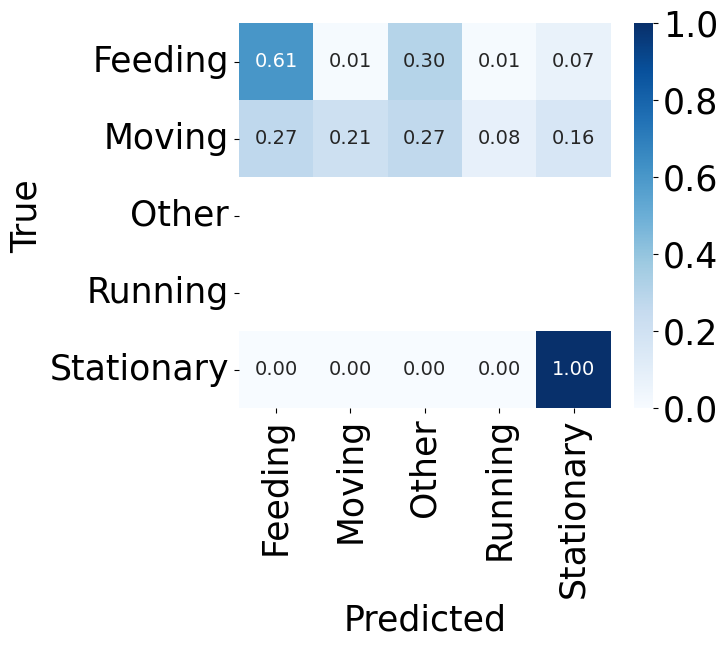

In [34]:
uncalibrated_predictions = uncalibrated_predictions.dropna(subset=['behavior']).copy()
cm = confusion_matrix(
    uncalibrated_predictions['behavior'],
    uncalibrated_predictions['behavior_pred'],
    labels=label_encoder.classes_
)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    vmin=0, vmax=1,
    annot_kws={"size": 14}
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


/tmp/ipykernel_1647754/3264214179.py:7: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)


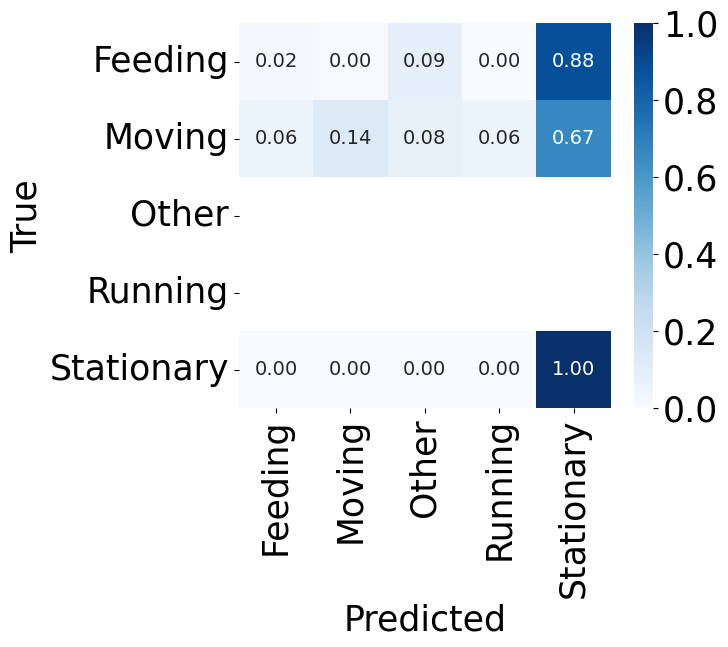

In [35]:
calibrated_predictions = calibrated_predictions.dropna(subset=['behavior']).copy()
cm = confusion_matrix(
    calibrated_predictions['behavior'],
    calibrated_predictions['behavior_pred'],
    labels=label_encoder.classes_
)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    vmin=0, vmax=1,
    annot_kws={"size": 14}
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
